<a href="https://colab.research.google.com/github/LennartKeller/TextklassifikationsProjekt2019/blob/master/Neuronale_Netze_mit_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
import numpy as np
import pandas as pd
import time
from scipy.stats import pearsonr


In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
from keras.utils import to_categorical

In [896]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/full_taggeddataset.csv')

In [898]:
#df_train, df_test = train_test_split(df[df.period == 'P1'], random_state=42, test_size=0.1)



#le = LabelEncoder()
#cl_train = le.fit_transform(df_train.lemmas)
#cl_test = le.fit_transform(df_test.lemmas)

#cg_train = le.fit_transform(df_train.genre)
#cg_test = le.fit_transform(df_test.genre)



#x_train = num_samples(x_train)
#x_test = num_samples(x_test)


df.lemmas

0      so kommen ihr die Löwritter schwermütig vor ? ...
1      arm Herz / lassen ab zu hoffen / weil die glüc...
2      ach / ich sein schon so müde / die ich kaum me...
3      so sein ! er lassen ich hoch und überhoch bela...
4      vertraute Charmium / dies sein -- Lebens-Höle ...
                             ...                        
655    Kamerad ! daheim in die Silvester = Gottesdien...
656    eine jede Uebergang in die Leben haben sein be...
657    andächtig Christ , Geliebte in die Herr ! als ...
658    darum wollen wir mit getroster Zuversicht er b...
659    die Eingliederung unser evang. Jugendverein in...
Name: lemmas, Length: 660, dtype: object

In [0]:
df_train = df[df.period == 'P1']
df_test = df[df.period != 'P1']

x_train = df_train.lemmas
y_train = df_train.genre

x_test = df_test.lemmas
y_test = df_test.genre

In [900]:
max_len = 1000
num_max = 5000
# preprocess
le = LabelEncoder()
tags_train = le.fit_transform(df_train.genre)
tags_test = le.fit_transform(df_test.genre)
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(df_train.lemmas)


seq_texts_train = tok.texts_to_sequences(df_train.lemmas)
seq_texts_test = tok.texts_to_sequences(df_test.lemmas)
word_index = tok.word_index
print('Found %s unique tokens.' % len(word_index))
cnn_texts_seq_train = sequence.pad_sequences(seq_texts_train,maxlen=max_len)
cnn_texts_seq_test = sequence.pad_sequences(seq_texts_test,maxlen=max_len)
np.unique(tags_train)

tags_train = to_categorical(tags_train)
tags_test = to_categorical(tags_test)


tags_test

Found 20861 unique tokens.


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [901]:
from keras.optimizers import SGD

def get_cnn_model_v1(n_classes, hiddenlayer_size=500, n_hiddenlayer=0):   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(input_dim=1000,
                        output_dim=50,
                        input_length=max_len))
    #model.add(Dropout(0.5))
    model.add(Conv1D(filters=16,
                     kernel_size=3,
                     padding='same',
                     activation='linear'))
    model.add(SpatialDropout1D(0.5))
    model.add(MaxPooling1D(strides=30))
    model.add(LSTM(units=16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    for i in range(n_hiddenlayer):
        model.add(Dense(hiddenlayer_size, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    #sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

model = get_cnn_model_v1(n_classes=len(np.unique(le.classes_)))
history = model.fit(cnn_texts_seq_train,tags_train,batch_size=64,epochs=20,verbose=1,validation_data=(cnn_texts_seq_test, tags_test))

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_87 (Embedding)     (None, 1000, 50)          50000     
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 1000, 16)          2416      
_________________________________________________________________
spatial_dropout1d_44 (Spatia (None, 1000, 16)          0         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 34, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 34, 16)            2112      
_________________________________________________________________
flatten_47 (Flatten)         (None, 544)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 256)             

In [0]:
import matplotlib.pyplot as plt

def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

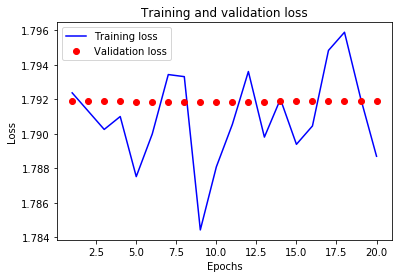

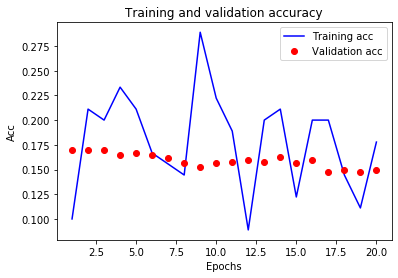

In [903]:
plot_results(history)
